# Introduction

Here, I am going to remove face mask of a person using autoencoder. To get better understanding of autoencoder and how it works you can visit my another notebook https://www.kaggle.com/theblackmamba31/autoencoder-removing-noise-from-mnist-digits, also I have some other notebook showing application of autoencoder, So you can visit my profile if you are really intrested in autoencoder. Here, I have defined the architecture of autoencoder it's application.
Let's Start

<img src = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTOkFwIF09DEVcgunZk_3EPp6FMWcxx8AUDRA&usqp=CAU' height = '600px' width = '600px'>

## Objective: Main aim of this notebook is to find face behind the mask using autoencoder.

## Import Necessary Libraries

In [19]:
!pip install tensorflow

In [20]:
!pip install keras

In [21]:
!pip install opencv-python

In [1]:
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import numpy as np
import os
import re


## Load data
Here I am going to load only 2500 images each with mask and no mask. These images are converted to an array and are appended in empty array. Here I also have defind function to load data serially. 

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

mask_path = r'C:/Users/rajan/Desktop/Dataset/with_mask'
mask_array = []

image_path = r'C:/Users/rajan/Desktop/Dataset/without_mask'
img_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
mask_file = sorted_alphanumeric(os.listdir(mask_path))
for i in tqdm(mask_file):
    #here i have only load 2500 images.
    if i == 'with-mask-default-mask-seed2500.png':
        break
    else:    
        image = cv2.imread(mask_path + '/' + i,1)

          # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))

        # normalizing image 
        image = image.astype('float32') / 255.0

        #appending normal normal image    
        mask_array.append(img_to_array(image))

  
    
for i in tqdm(image_file):
 
    if i == 'seed2500.png':
        break
    
    else:
        image = cv2.imread(image_path + '/' + i,1)

        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))

        # normalizing image 
        image = image.astype('float32') / 255.0
        # appending normal sketch image
        img_array.append(img_to_array(image))

   
    

 25%|███████████████████▎                                                         | 2500/10000 [01:29<04:27, 28.00it/s]


## Plot image pair

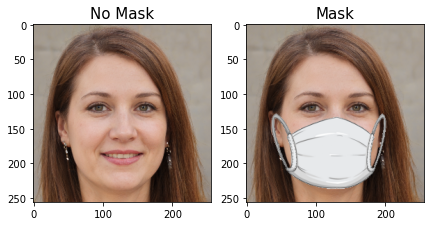

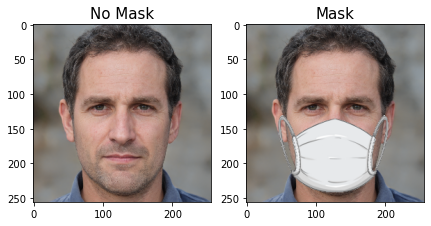

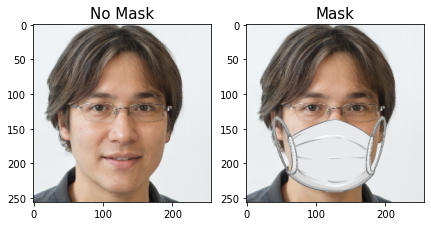

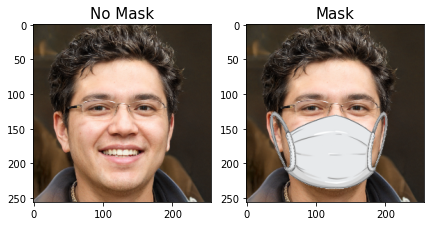

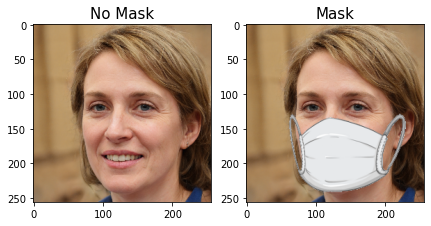

In [3]:
def plot_image_pair(images = 5):
    for i in range(images):
        plt.figure(figsize = (7,7))
        plt.subplot(1,2,1)
        plt.title("No Mask", fontsize = 15)
        plt.imshow(img_array[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,2,2)
        plt.title("Mask", fontsize = 15)
        plt.imshow(mask_array[i].reshape(SIZE, SIZE, 3))
        
        
        
plot_image_pair(5)
        
        

## Slicing and reshaping
Here i have used 2300 images for training and remaining 200 for testing.

In [4]:
train_mask_image = mask_array[:2300]
train_image = img_array[:2300]
test_mask_image = mask_array[2300:]
test_image = img_array[2300:]
# reshaping
train_mask_image = np.reshape(train_mask_image,(len(train_mask_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train no mask image shape:',train_image.shape)
test_mask_image = np.reshape(test_mask_image,(len(test_mask_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test no mask image shape',test_image.shape)

Train no mask image shape: (2300, 256, 256, 3)
Test no mask image shape (200, 256, 256, 3)


## Defining our model

Here I have used Conv2D and MaxPool2D in encoder network for downsampling. Latent vector is of shape (16,16,64). This latent vector is input for decoder network, decoder network tries to reconstruct images and tries to reduce reconstruction loss by upsampling this latent vector.

In [5]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="img")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = MaxPool2D(pool_size = (2,2))(x)
x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), padding = 'valid')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size = (2,2))(x)
x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Conv2D(filters = 128 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
x = Conv2D(filters = 256 , kernel_size = (3,3), padding = 'same')(x) 
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder = tf.keras.Model(encoder_input, encoder_output)



decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
x = UpSampling2D(size = (2,2))(decoder_input)
x = Conv2D(filters = 256, kernel_size = (3,3),  padding = 'same')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3),  padding = 'same')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Conv2D(filters = 164, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)

x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3),  padding = 'same')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = UpSampling2D(size = (2,2) )(x) 
x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
decoder_output = Conv2D(filters = 3, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LeakyReLU()(x)

# final model
model = keras.Model(encoder_input, decoder_output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1849

## Compiling our model

In [6]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [7]:
def ben():
    x = model.fit(train_mask_image, train_image, epochs = 50, verbose = 1)
   
    return x.epoch, x.x['acc'][-1]

_,_ = ben()

Epoch 1/50
72/72 [==============================] - 697s 10s/step - loss: 0.5550 - acc: 0.5965
Epoch 2/50
72/72 [==============================] - 779s 11s/step - loss: 0.1072 - acc: 0.8283
Epoch 3/50
72/72 [==============================] - 703s 10s/step - loss: 0.0905 - acc: 0.8352
Epoch 4/50
72/72 [==============================] - 758s 11s/step - loss: 0.0777 - acc: 0.8467
Epoch 5/50
72/72 [==============================] - 726s 10s/step - loss: 0.0731 - acc: 0.8408
Epoch 6/50
72/72 [==============================] - 683s 9s/step - loss: 0.0695 - acc: 0.8447
Epoch 7/50
72/72 [==============================] - 713s 10s/step - loss: 0.0676 - acc: 0.8562
Epoch 8/50
72/72 [==============================] - 797s 11s/step - loss: 0.0610 - acc: 0.8543
Epoch 9/50
72/72 [==============================] - 776s 11s/step - loss: 0.0634 - acc: 0.8549
Epoch 10/50
72/72 [==============================] - 762s 11s/step - loss: 0.0606 - acc: 0.8634
Epoch 11/50
72/72 [==============================]

AttributeError: 'History' object has no attribute 'x'

## Model evaluation

In [8]:
loss_acc= model.evaluate(test_mask_image, test_image)
print("Loss: ",loss_acc[0])
print('Accuracy: ', np.round(loss_acc[1],2) * 100)

7/7 [==============================] - 30s 2s/step - loss: 0.0393 - acc: 0.9135
Loss:  0.0393429659307003
Accuracy:  91.0


## plotting images

In [9]:
def plot_images(start = 0, end = 5):
    for i in range(start, end, 1):
        plt.figure(figsize = (10,10))
        plt.subplot(1,3,1)
        plt.title("No Mask", fontsize = 12)
        plt.imshow(test_image[i])
        plt.subplot(1,3,2)
        plt.title("Mask", fontsize = 12)
        plt.imshow(test_mask_image[i])
        plt.subplot(1,3,3)
        plt.title("Predicted", fontsize = 12)
        prediction = model.predict(test_mask_image[i].reshape(1,SIZE, SIZE, 3)).reshape(SIZE, SIZE, 3)
        plt.imshow(prediction)
        plt.show()
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


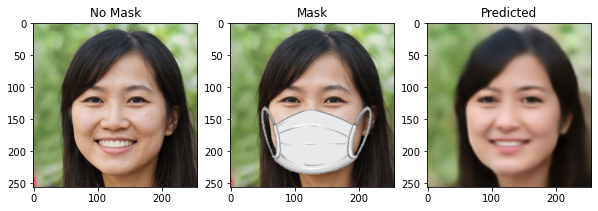

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


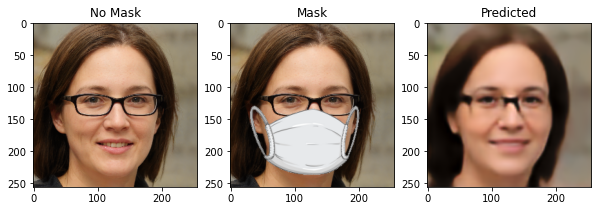

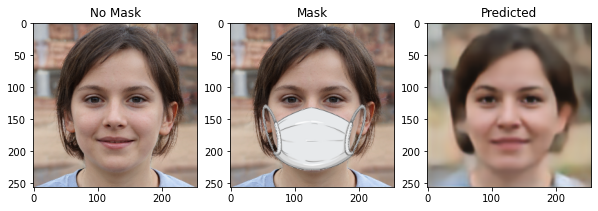

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


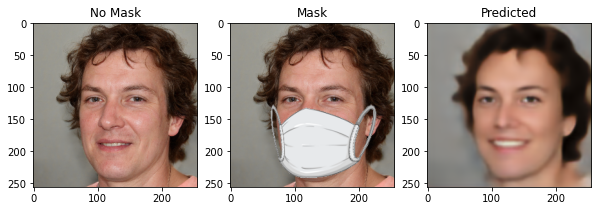

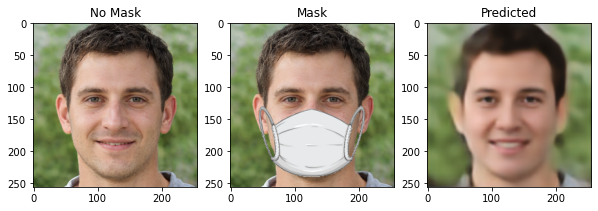

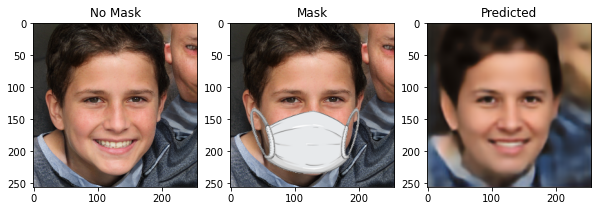

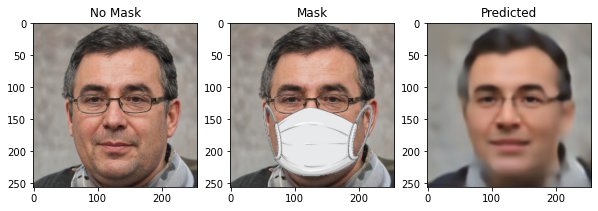

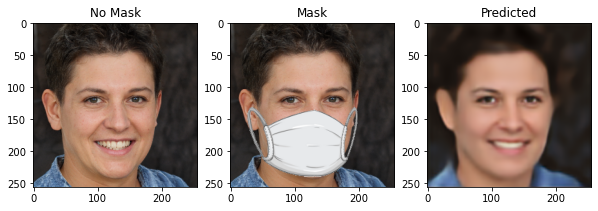

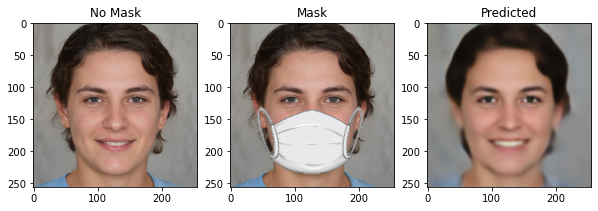

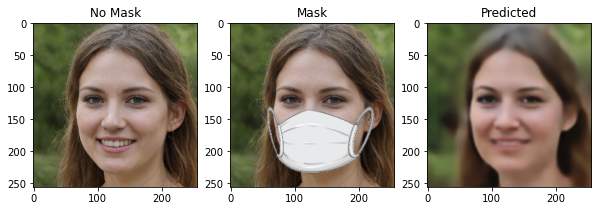

In [10]:
plot_images(20,30)

In [11]:
model.metrics_names

['loss', 'acc']